# Bedre OCR av gamle styringsdokumenter med fraktur

Nasjonalbiblioteket har en enorm digitalisert samling som er tilgjengelig via [Nettbiblioteket](https://www.nb.no/search). Mens nyere tekster kan være avlevert digitalt, er store deler av samlingen skannet fra papirutgaver. Disse skannede dokumentene er da i første omgang tilgjengelig som bilder av hver enkelt side. For lesing av tekster «online» fungerer dette bra. Tekster som er fritt tilgjengelig, kan som regel også lastes ned som pdf. Til søk og annen maskinell behandling av tekst, eksempelvis som treningsdata til språkmodeller fungerer slike bilder dårlig: Det er nødvendig å lese skriften ut av bildene, og slik produsere tekstfiler med utgangspunkt i bildene. Denne teknologien kalles Object Character Recognition (OCR). 

Alle bøker og tidsskrifter som er tilgjengelige i Nettbiblioteket er også prosessert med OCR -- det er resultatet av denne prosesseringen som gjør at vi kan søke i nettbiblioteket. Men kvaliteten på denne OCR-en kunne ha vært bedre. At det er utfordringer med kvaliteten kommer blant annet av at teknologien har blitt bedre etter at dokumente ble scannet første gang. At det er stor variasjon i fonter, formater og papirkvalitet gjør nok også sitt til at det er utfordrende å få tilfredstillende kvalitet i hele samlingen. 

To fenomener gir ekstra utfordringer. Det første er dokumenter satt med fraktur. Her er kvaliteten på OCR dårlig og Nasjonalbiblioteket jobber for tiden med å forbedre dette, blant annet med å trenge opp en egen modell for gjennkjenning av bokstaver og tall i fraktur. En annen utfordring er dokumenter som er trykket på tynt, gulnet papir hvor baksiden «blør gjennom» og lager støy på det scannede dokuemtnet. Vi skal komme nærmere tilbake til denne utfordringen.

Noe av motivasjonen for å jobbe med denne teknologien, er at mye eldre rettskilder og annen styringsprosa bare er tilgjengelig i fraktur. En teknologi som oversetter disse tekstene til mer lettleste latinske skrifttyper bidrar derfor med å gjøre dettte materialet tilgjengelig for alle. I tillegg er det også viktig å kunne forske på disse tekstene med maskinelle metodier. Til sist: Det er også et materiale som kan være nyttig for opptrening av språkmodeller. Bedre kvalitet på treningsdataene vil presumptivt gi bedre kvalitet på språkmodellene. Kanskje kan vi også håpe på at vi etter hvert får språkmodeller som er godt informert om norsk rettslig og adminsitrativ histoire.

## Tesseract
Nasjonalbiblioteket bruker Tesseract til OCR. Tesseract er åpen kildekode og er fritt tilgjengelig for alle. Nasjonalbiblioteket har publisert et eget grensesnitt for lese OCR på bøker i Nettbiblioteket på [https://github.com/Sprakbanken/tesseract_massproduction_docker](https://github.com/Sprakbanken/tesseract_massproduction_docker). Høsten 2024 har Nasjonalbiblioteket trent opp en ny modell for OCR av tekster med fraktur: **norprint_storting**. Dette er en blandingsmodell trent til både å lese fraktur og antikva fonter. I det følgende tar vi utgangspunkt i denne modellen.

## Funksjon for å bruke Tesseract med Nasjonalbibliotekets modell

Vi tar utgangspunkt i Nasjonalbibliotekets funksjon *process.py*. Den er skrevt for å brukes i Docker. Vi har tilpasset den litt:
- Bruker lokalt installert Tesseract
- Python-scriptet kan kjøres lokalt, dvs. uten Docker.
- Har lagt inn mulighet for å variere noen av Tesseracts parametre.
- Mulighet til å velge hvilke sider som skal kjøres. (Det er mulig det finnes en enklere måte å gjøre dette på)
- Lagrer bildene med informasjon om hvilke parametre som er brukt

In [15]:
import os
import requests
import subprocess
from io import BytesIO
from IPython.display import Image, display, Markdown

os.environ['TESSDATA_PREFIX'] = './models/'
model      = 'norprint_storting'

def process_urn(urn, start_page, end_page, dpi, model='norprint_storting'):
    # Fetch the manifest JSON
    manifest_url = f"https://api.nb.no/catalog/v1/iiif/{urn}/manifest"
    manifest = requests.get(manifest_url)
    
    # Check if the request was successful
    if manifest.status_code != 200:
        raise Exception(f"Failed to fetch manifest. Status code: {manifest.status_code}")
    
    # Parse JSON
    manifest_json = manifest.json()
    
    # Check if "sequences" key exists
    if "sequences" not in manifest_json:
        raise KeyError("'sequences' key not found in manifest JSON")
    
    # Set up folder path for saving outputs
    folder_path = os.path.join('./data', urn.replace(":", "_"))
    os.makedirs(folder_path, exist_ok=True)
    
    # Get total number of pages
    total_pages = len(manifest_json["sequences"][0]["canvases"])
    
    # Ensure page range is within the total number of pages
    start_page = max(1, start_page)  # Ensure start_page is at least 1
    end_page = min(total_pages, end_page)  # Ensure end_page is within bounds
    
    # Process each image (canvas) within the specified range
    for idx in range(start_page - 1, end_page):  # Adjust for 0-based index
        canvas = manifest_json["sequences"][0]["canvases"][idx]
        image_id = canvas["images"][0]["@id"].split('/')[-1].replace(":", "_")
        # setter image_id til sidetall midlertidig for å jobbe med kortere filnavn
        image_id = str(idx)
        print(image_id)
        image_url = canvas["images"][0]["resource"]["@id"].replace('/full/full/', '/full/' + scaling + '/')
        out_path = os.path.join(folder_path, image_id) + '_' + scaling.replace(":", "_") + '_treshold_' + str(tresholding_method) + '_dpi_' + str(dpi)
        #print(out_path)
    
        # Download the image to a local temporary file
        print(f"Processing page {idx + 1}: {image_url}")
        response = requests.get(image_url)
        with open(f"{out_path}.jpg", 'wb') as img_file:
            img_file.write(response.content)
        
        tesseract_cmd = [
            "tesseract", f"{out_path}.jpg", out_path, "-l", model, 
            "-c", "preserve_interword_spaces=1",
            "-c", "tessedit_write_images=true",
            "-c", "thresholding_method=" + str(tresholding_method) + '"',
            "-c", "tessedit_create_txt=1"
        ]
        if dpi == 400: 
            tesseract_cmd.extend(["--dpi", "400"])
        elif dpi == 200:
            tesseract_cmd.extend(["--dpi", "200"])
        subprocess.run(tesseract_cmd)
        print(f"Output saved to: {out_path}")

def vis_text(path):
    with open(path, 'r') as file:
        content = file.read()
        display(Markdown(f"> ```\n> {content[:600].replace('\n', '\n> ')}\n> ```"))




## Utgangspunktet
Vi starter med å bruke de samme paramteterene som i Nasjonalbibliotekets kode fra. Etter hvert skal vi variere disse parametrene. For å holde noe konstant tester vi de ulike innstillingene av parametrene på én side. Vi bruker da side 830 fra Departements-tidene 1867 -- en kongelig resolusjon om å oversette Grunnloven til kvensk og samisk, eller  «kvænsk» og «lappisk» som var skrivemåten dengang. Tester på én side er selvfølgelig ikke nok til å trekke slutninger om hvilke verdier som bør velges for å skanne større samlinger. Vi er i første omgang ute etter å forstå hvordan Tesseract prosesserer bilder og å forstå hvordan noen av parametrene vi kan sette i Tesseract påvirker den genererte teksten. Dermed får vi et grunnlag for å sette opp mere omfattende tester.

Vi kjører først Tesseract med parametrene Nasjonalbibliotekets *tesseract_massproduction*. Så henter vi fram bildet.

In [16]:
urn        = 'URN:NBN:no-nb_digitidsskrift_2014042881056_001'
start_page = 892  
end_page   = 892 
scaling    = 'pct:50'
#scaling    = 'full'
tresholding_method = 0
dpi = 400
process_urn(urn, start_page,end_page,dpi)


891
Processing page 892: https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digitidsskrift_2014042881056_001_0892/full/pct:50/0/native.jpg


Detected 241 diacritics


Output saved to: ./data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_pct_50_treshold_0_dpi_400


## Det skannede bildet
Funksjonen fra Nasjonalbiblioteket vi bruker her, laster ned sider som et jpg-bilde. Dette bildet er utgangspunktet for behandlingen med OCR. Vi tar en første titt på bildet. Vi laster ned side 830 fra Departements-tidende 1867

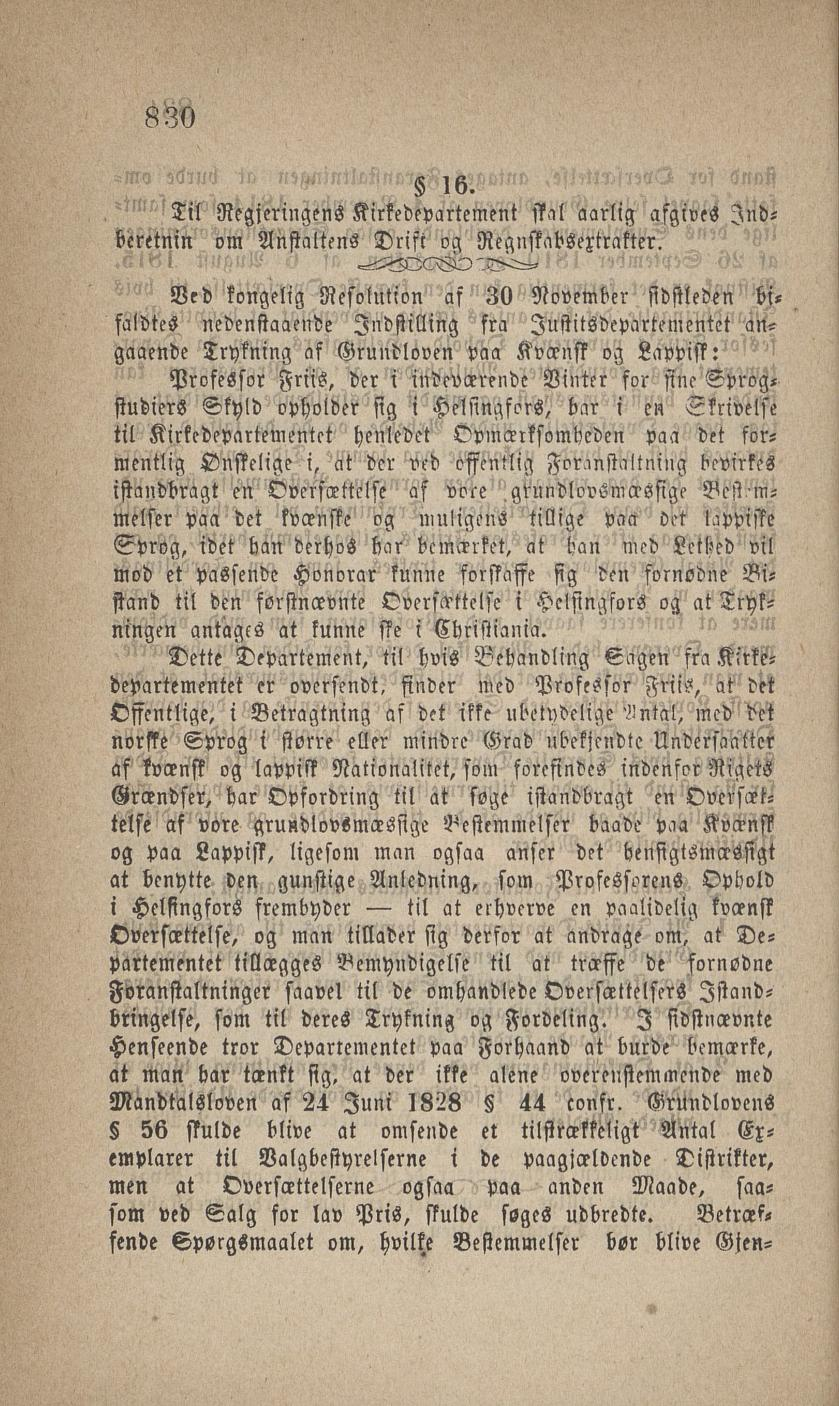

In [17]:
display(Image(filename='./data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_pct_50_treshold_0_dpi_400.jpg'))

### Karakteristikker ved bildet:
- Fraktur
- Gulnet papir
- Baksiden skinner gjennom

## Den genererte teksten.

La oss også se på den OCR-genererte teksten. Vi viser bare de 600 første tegnene.

In [5]:
text_file_path = './data/URN_NBN_no-nb_digitidsskrift_2014042881056_001//891_pct_50_treshold_0_dpi_400.txt'
vis_text(text_file_path)

> ```
> 830
> 
> 5             § 16.
> .    Til Regferingens Kirkedepartement skal aarlig afgives Ind-
> beretnin om Anftaltens 3; 3 377 Nmst poertratter-
> 
> ––ØØ
> 
> Bed kongelig Feføkition eake af 30 November sidstleden bi-
> 
> faldtes nedenstaaende Indstilling fra Justitsdepartementet an-
> gaaende Trykning af Grundloven paa Kvænsk og Nadrist    §
> 
> Professor Friis, der i indeværende Vinter for sine Sprog-
> studiers Skyld opholder sig i Helsingfors, bar i en Skrivelse
> til Kirkedepartementet henledet Opmærksomheden paa det for-
> mentlig Ønskelige i, at der ved offentlig Foranstaltning bevirkes
> istandbragt en Oversættels
> ```

### Karakteristikker ved den genererte teksten:
- 830 er sidetallet
- Noen overflødig tegn til venstre ('5', '.' og '––ØØ')
- Mange feilaktig identifiserte tegn.
- Siste avsnitt i utdragete er bedre. (Fra 'Professor Friis...')

## Kvaliteten på det nedlastede bildet.

For å undersøke hvordan denne prosessen kan forbedres, undersøker vi de enkelte trinn i prosessen. Vi begynner med det nedlastede bildet. Tesseract laster altså ned bilder fra Nettbiblioteket. Vi forstørrer et utsnitt av dette bildet.

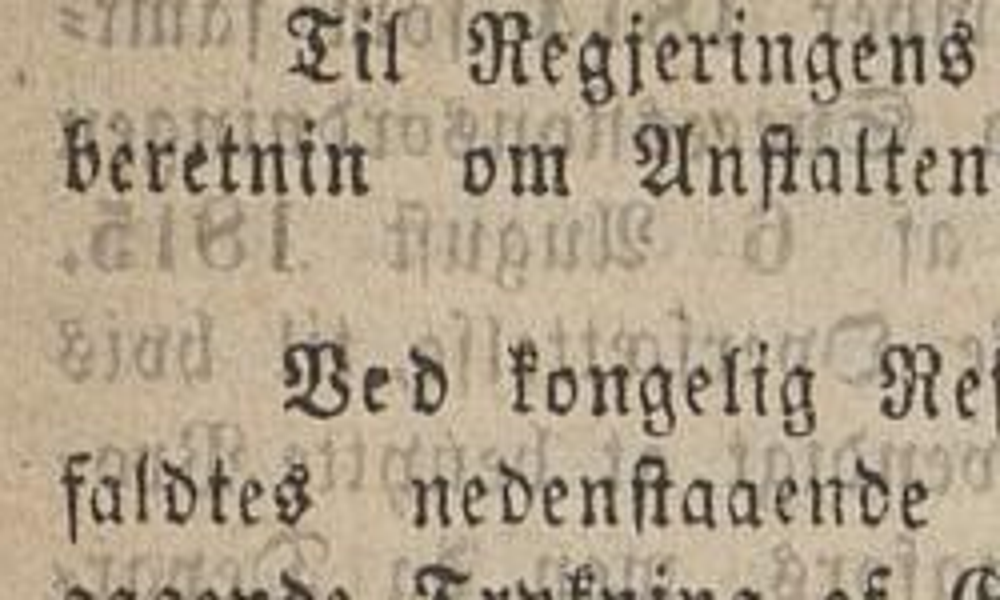

In [19]:
from PIL import Image

# Load the image
image_path = './data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_pct_50_treshold_0_dpi_400.jpg'
image = Image.open(image_path)

# Define the crop box (left, upper, right, lower)
# Adjust these values as needed to crop the desired area
crop_box = (100, 200, 350, 350)  # Example values
cropped_image = image.crop(crop_box)

# Optional: Zoom by resizing
zoom_factor = 4  # Adjust zoom level as desired
zoomed_image = cropped_image.resize((cropped_image.width * zoom_factor, cropped_image.height * zoom_factor))

display(zoomed_image)

Her ser vi tydelig at baksiden skinner gjennom. Vi kan også se at bildet er litt uklart, og det ser ut til å ha litt dårligere kvalitet enn det som er tilgjengelig i Nettbibliotekets nettleser. Ser en sammenligning se [https://www.nb.no/items/0fe9ce0706a8573abc1be2065cb7d07f?page=891](https://www.nb.no/items/0fe9ce0706a8573abc1be2065cb7d07f?page=891).

En mulig forklaring på at bildet har litt dårligere kvalitet i den nedlastede versjonen, er at det er lastet ned med en nedskalering. I koden fra Nasjonalbiblioteket er siden lastet ned med `pct:50`. Vi laster ned uten skalering og setter de to bildene opp ved siden av hverandre. 

In [6]:
scaling    = 'full'
tresholding_method = 0
dpi = 400
process_urn(urn, start_page,end_page,dpi)

891
Processing page 892: https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digitidsskrift_2014042881056_001_0892/full/full/0/native.jpg


Detected 618 diacritics


Output saved to: ./data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_full_treshold_0_dpi_400



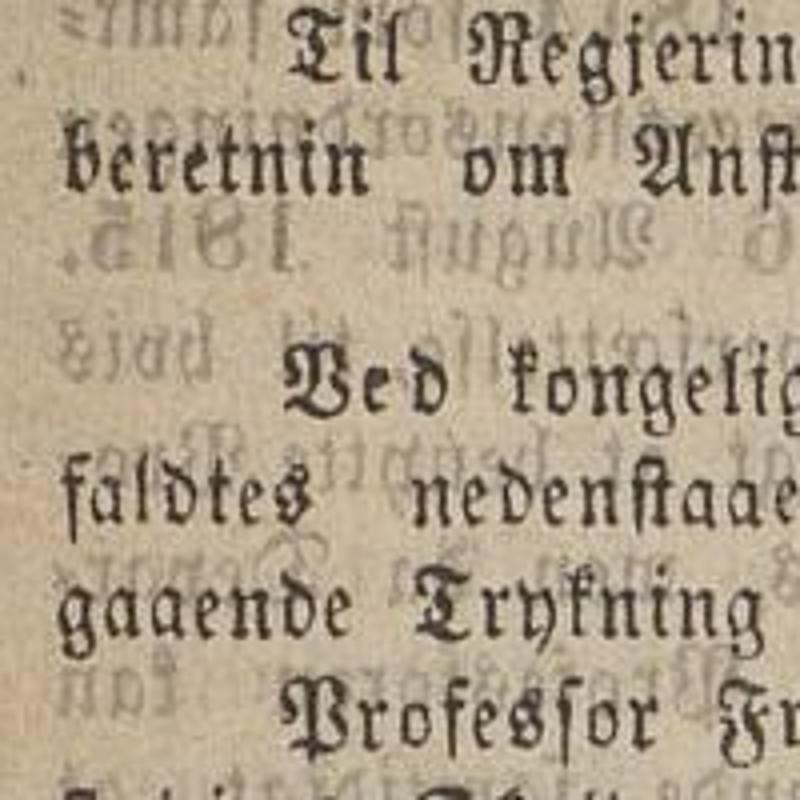
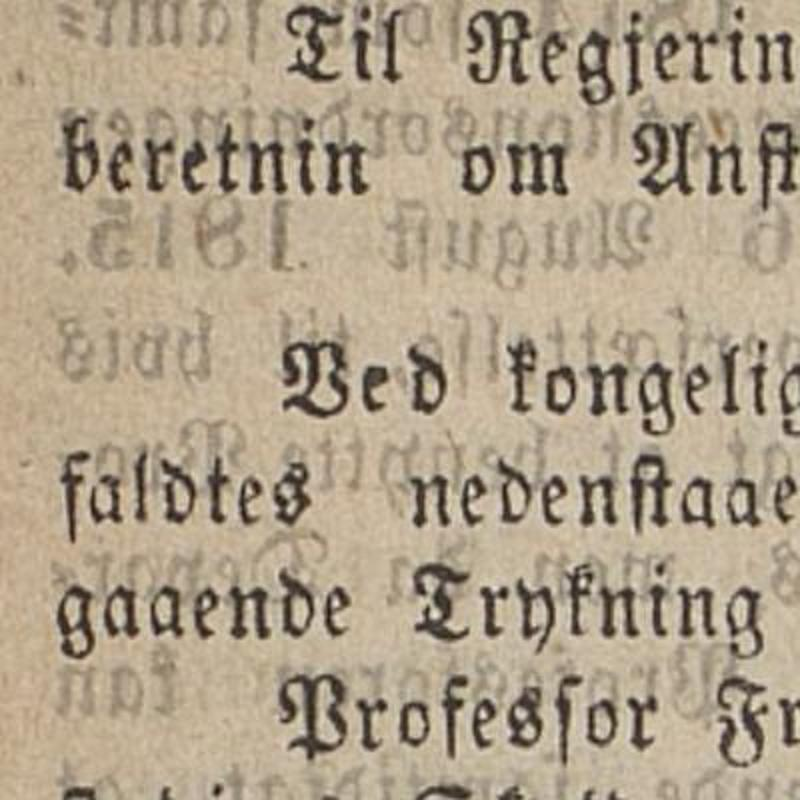

In [7]:
from PIL import Image
from IPython.display import display, HTML
import io
import base64

# Load and prepare images
image_path_scaled = './data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_pct_50_treshold_0_dpi_400.jpg'
image_scaled = Image.open(image_path_scaled)

image_path_unscaled = './data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_full_treshold_0_dpi_400.jpg'
image_unscaled = Image.open(image_path_unscaled)

# Crop the images (adjust the crop boxes as needed)
crop_box_scaled = (100, 200, 300, 400)  # Example crop values
crop_box_unscaled = (200, 400, 600, 800)  # Example crop values

cropped_scaled_image = image_scaled.crop(crop_box_scaled)
cropped_unscaled_image = image_unscaled.crop(crop_box_unscaled)

# Optional: Zoom by resizing
zoom_factor_scaled = 4  # Adjust zoom level as desired
zoom_factor_unscaled = 2

zoomed_scaled_image = cropped_scaled_image.resize(
    (cropped_scaled_image.width * zoom_factor_scaled, cropped_scaled_image.height * zoom_factor_scaled)
)
zoomed_unscaled_image = cropped_unscaled_image.resize(
    (cropped_unscaled_image.width * zoom_factor_unscaled, cropped_unscaled_image.height * zoom_factor_unscaled)
)

# Convert images to base64 strings for embedding in HTML
def pil_image_to_base64(img):
    buffered = io.BytesIO()
    img.save(buffered, format='JPEG')
    img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return img_str

img_str_scaled = pil_image_to_base64(zoomed_scaled_image)
img_str_unscaled = pil_image_to_base64(zoomed_unscaled_image)

# Create HTML with CSS to display images side by side
html_content = f"""
<style>
    .image-container {{
        display: flex;
        gap: 10px;
    }}
    .image-block {{
        flex: 1;
        text-align: center;
    }}
    .image-block img {{
        max-width: 100%;
        height: auto;
        border: 1px solid #ccc;
        border-radius: 5px;
    }}
    .image-block h3 {{
        margin-top: 0;
    }}
</style>
<div class="image-container">
    <div class="image-block">
        <h3>Skalert bilde</h3>
        <img src="data:image/jpeg;base64,{img_str_scaled}" alt="Scaled Image"/>
    </div>
    <div class="image-block">
        <h3>Uskalert bilde</h3>
        <img src="data:image/jpeg;base64,{img_str_unscaled}" alt="Unscaled Image"/>
    </div>
</div>
"""

display(HTML(html_content))


Vi ser at bildet til høyre -- det som ikke er nedskalert -- er litt klarere enn bildet til vestre. Omrisset av bokstavene er tydeligere når bildet ikke er skalert ned. Noe overraskende er teksten fra OCR mye bedre med det uskalerte bildet (til høyre). Vi viser de to ocr-ene side om side.

In [8]:
from IPython.display import display, HTML
import html

# Load and prepare text
text_file_path_scaled = './data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_pct_50_treshold_0_dpi_400.txt'
text_file_path_unscaled = './data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_full_treshold_0_dpi_400.txt'

with open(text_file_path_scaled, 'r') as file:
    content_scaled = file.read()

with open(text_file_path_unscaled, 'r') as file:
    content_unscaled = file.read()

# Escape HTML special characters
content_scaled_html = html.escape(content_scaled[:600])
content_unscaled_html = html.escape(content_unscaled[:600])

# Create HTML with CSS to display texts side by side
html_content = f"""
<style>
    .text-container {{
        display: flex;
        gap: 10px;
    }}
    .text-block {{
        flex: 1;
        padding: 10px;
        margin: 0;
        border: 1px solid #ccc;
        border-radius: 5px;
        background-color: #f9f9f9;
        overflow: auto;
        font-family: monospace;
        font-size: 14px;
        white-space: pre-wrap;
    }}
    .text-block h3 {{
        margin-top: 0;
    }}
</style>
<div class="text-container">
    <div class="text-block">
        <h3>Fra skalert bilde</h3>
        <pre>{content_scaled_html}</pre>
    </div>
    <div class="text-block">
        <h3>Fra uskalert bilde</h3>
        <pre>{content_unscaled_html}</pre>
    </div>
</div>
"""

display(HTML(html_content))


Forskjellen er overraskende stor. Det ser ut til at dette kommer av at Tesseract får et parameter der 'dpi' settes til '400'. Dette parameteret gir et tips til Tesseract om hvilken oppløsning bildet som skal prosesseres har; det betyr ikke at Tesseract vil bruke akkurat denne verdien, men at den tar den som et utgangspunkt når den estimerer hva riktig verdi skal være. Hvis vi ikke oppgir 'dpi', prøver Tesseract å finne korrect verdi selv.

I sammenligningen gir vi det samme «tipset» til både den skalerte og uskalerte versjonen bildet. La oss kjøre det skalerte bildet på nytt, men denne gangen lar vi Tesseract selv anslå dpi. 

In [9]:
urn        = 'URN:NBN:no-nb_digitidsskrift_2014042881056_001'
start_page = 892  
end_page   = 892 
scaling    = 'pct:50'
tresholding_method = 0
dpi = 0
process_urn(urn, start_page,end_page,dpi)

891
Processing page 892: https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digitidsskrift_2014042881056_001_0892/full/pct:50/0/native.jpg


Estimating resolution as 225
Detected 144 diacritics


Output saved to: ./data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_pct_50_treshold_0_dpi_0


Nå ser vi at Tesseract anslår oppløsningen til 225.



In [10]:
from IPython.display import display, HTML
import html

# Load and prepare text
text_file_path_400 = './data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_pct_50_treshold_0_dpi_400.txt'
text_file_path_0 = './data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_pct_50_treshold_0_dpi_0.txt'

with open(text_file_path_400, 'r') as file:
    content_scaled = file.read()

with open(text_file_path_0, 'r') as file:
    content_unscaled = file.read()

# Escape HTML special characters
content_scaled_html = html.escape(content_scaled[:600])
content_unscaled_html = html.escape(content_unscaled[:600])

# Create HTML with CSS to display texts side by side
html_content = f"""
<style>
    .text-container {{
        display: flex;
        gap: 10px;
    }}
    .text-block {{
        flex: 1;
        padding: 10px;
        margin: 0;
        border: 1px solid #ccc;
        border-radius: 5px;
        background-color: #f9f9f9;
        overflow: auto;
        font-family: monospace;
        font-size: 14px;
        white-space: pre-wrap;
    }}
    .text-block h3 {{
        margin-top: 0;
    }}
</style>
<div class="text-container">
    <div class="text-block">
        <h3>Fra nedskalert bilde med dpi=400</h3>
        <pre>{content_scaled_html}</pre>
    </div>
    <div class="text-block">
        <h3>Fra nedskalert bilde uten dpi-hint</h3>
        <pre>{content_unscaled_html}</pre>
    </div>
</div>
"""

display(HTML(html_content))


## Binærisering av bildet
Tesseract jobber bare med svart/hvit-bilder. De skannede teksten på Nasjonalbiblioteket er i farger. Det første trinnet i Tesseracts prosessering er derfor en binæring av bildet. Det er mange algoritmer som kan binærisere et fargbilde. Tesseract har tre slike alogritmer innebygd. For å undersøke effekten av denne algoritmen kan vi be Tesseract om å lagre det binære bildet, slik at vi kan studere det nærmere. Dette gjør vi ved å sette `tessedit_write_images=true`.

De ulike algoritmene for binærisering får vi ved å sette henholdvis:
- `tresholding_method = 0`
- `tresholding_method = 1`
- `tresholding_method = 2`

Hvis vi ikke setter noen verdi for `tresholding_method`, blir den satt til 0. De tre ulike veridene får Tesseract til å bruke tre ulike algoritmer.

### Treshold = 0

Vi ser først på det binæriserte bildet for et skalert bilde med `tresholding_method = 0`. (Dette er verdiene Nasjonalbiblioteket bruker)

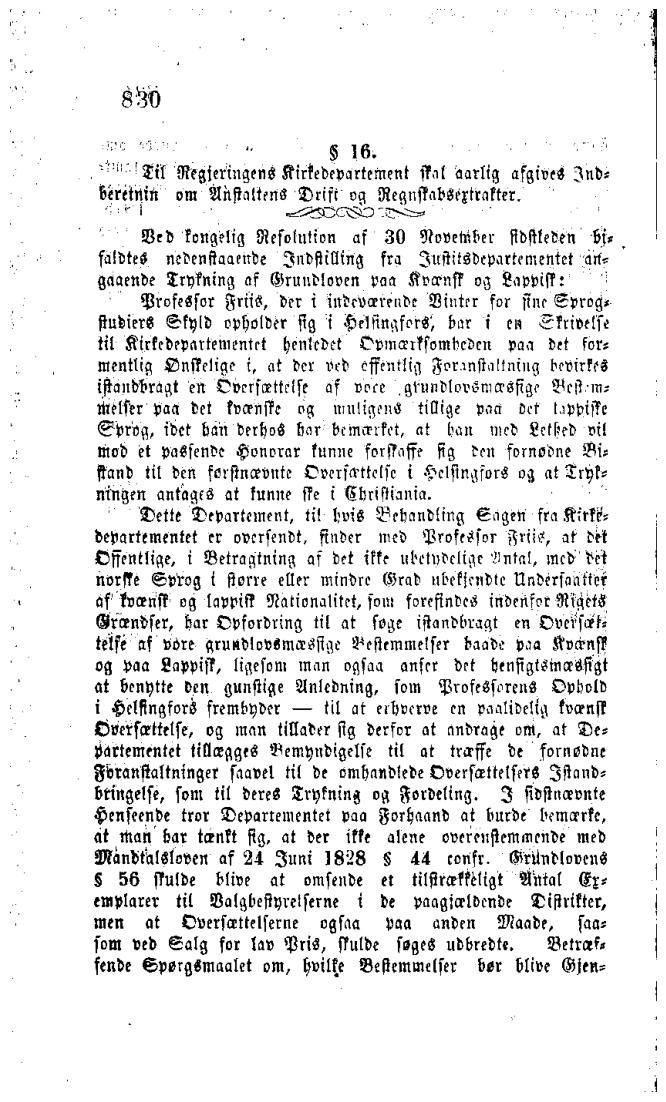

In [20]:


import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Open the TIFF image
image = PILImage.open('./data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_pct_50_treshold_0_dpi_400.processed.tif')

# Get the image dimensions
width, height = image.size

# Set figure size based on image size
fig = plt.figure(figsize=(width / 100, height / 100))  # Scale by 100 to get a reasonable display size

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axes for a cleaner look
plt.show()



### Treshold = 1

891
Processing page 892: https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digitidsskrift_2014042881056_001_0892/full/pct:50/0/native.jpg
Output saved to: ./data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_pct_50_treshold_1_dpi_400


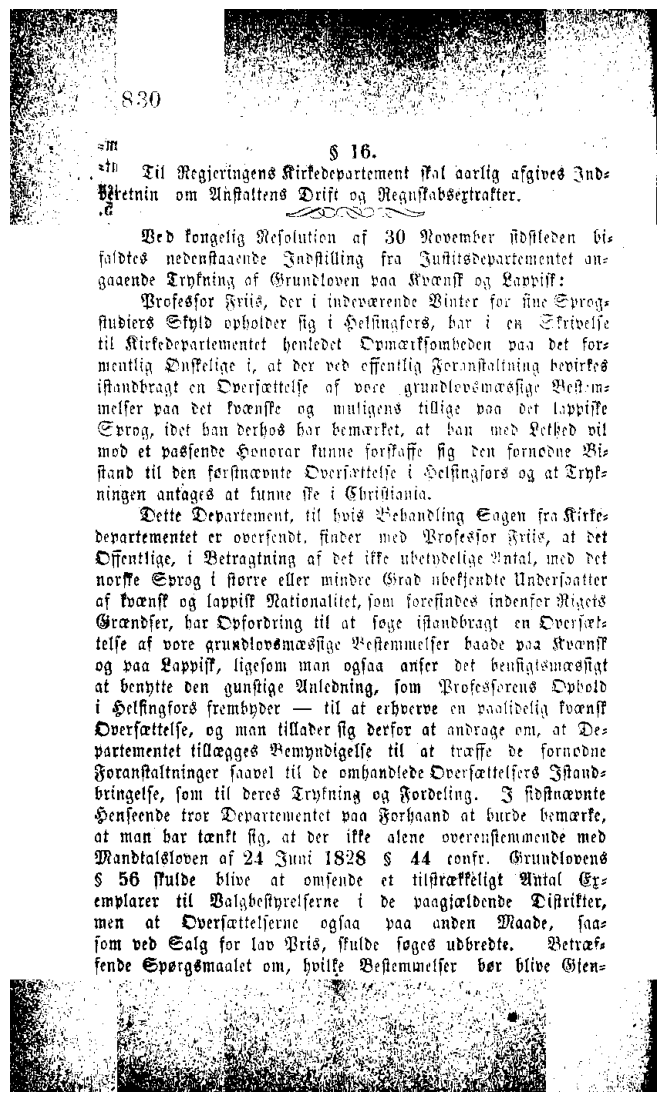

In [22]:
# Så prøver vi algoritme 1
urn        = 'URN:NBN:no-nb_digitidsskrift_2014042881056_001'
start_page = 892  
end_page   = 892 
scaling    = 'pct:50'
#scaling    = 'full'
tresholding_method = 1
dpi = 400
process_urn(urn, start_page,end_page,dpi)

import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Open the TIFF image
image = PILImage.open('./data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_pct_50_treshold_1_dpi_400.processed.tif')

# Get the image dimensions
width, height = image.size

# Set figure size based on image size
fig = plt.figure(figsize=(width / 100, height / 100))  # Scale by 100 to get a reasonable display size

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axes for a cleaner look
plt.show()


### Treshold = 2

891
Processing page 892: https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digitidsskrift_2014042881056_001_0892/full/pct:50/0/native.jpg
Output saved to: ./data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_pct_50_treshold_2_dpi_400


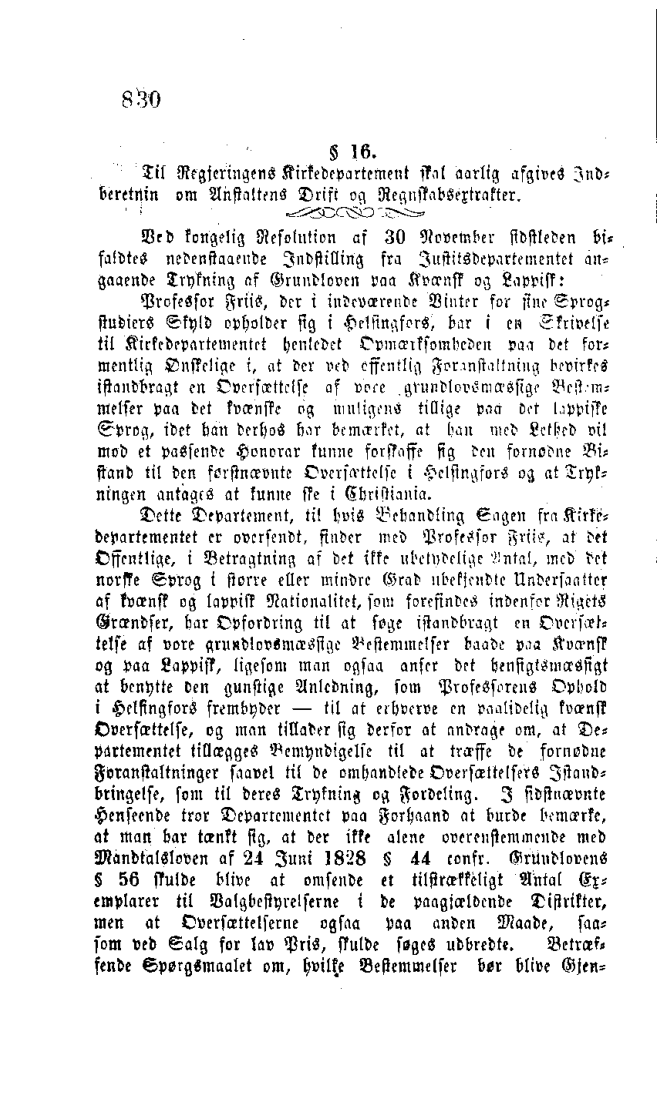

In [23]:
# Algoritme 2
# Så prøver vi algoritme 2
urn        = 'URN:NBN:no-nb_digitidsskrift_2014042881056_001'
start_page = 892  
end_page   = 892 
scaling    = 'pct:50'
#scaling    = 'full'
tresholding_method = 2
dpi = 400
process_urn(urn, start_page,end_page,dpi)

import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Open the TIFF image
image = PILImage.open('./data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_pct_50_treshold_2_dpi_400.processed.tif')

# Get the image dimensions
width, height = image.size

# Set figure size based on image size
fig = plt.figure(figsize=(width / 100, height / 100))  # Scale by 100 to get a reasonable display size

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axes for a cleaner look
plt.show()

## Binarisering uten skalering

Så prøver vi de tre binariseringsalgoritmene uten skalering av det nedlastede bildet.

### Treshold = 0

891
Processing page 892: https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digitidsskrift_2014042881056_001_0892/full/full/0/native.jpg


Estimating resolution as 440
Detected 618 diacritics


Output saved to: ./data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_full_treshold_0_dpi_0


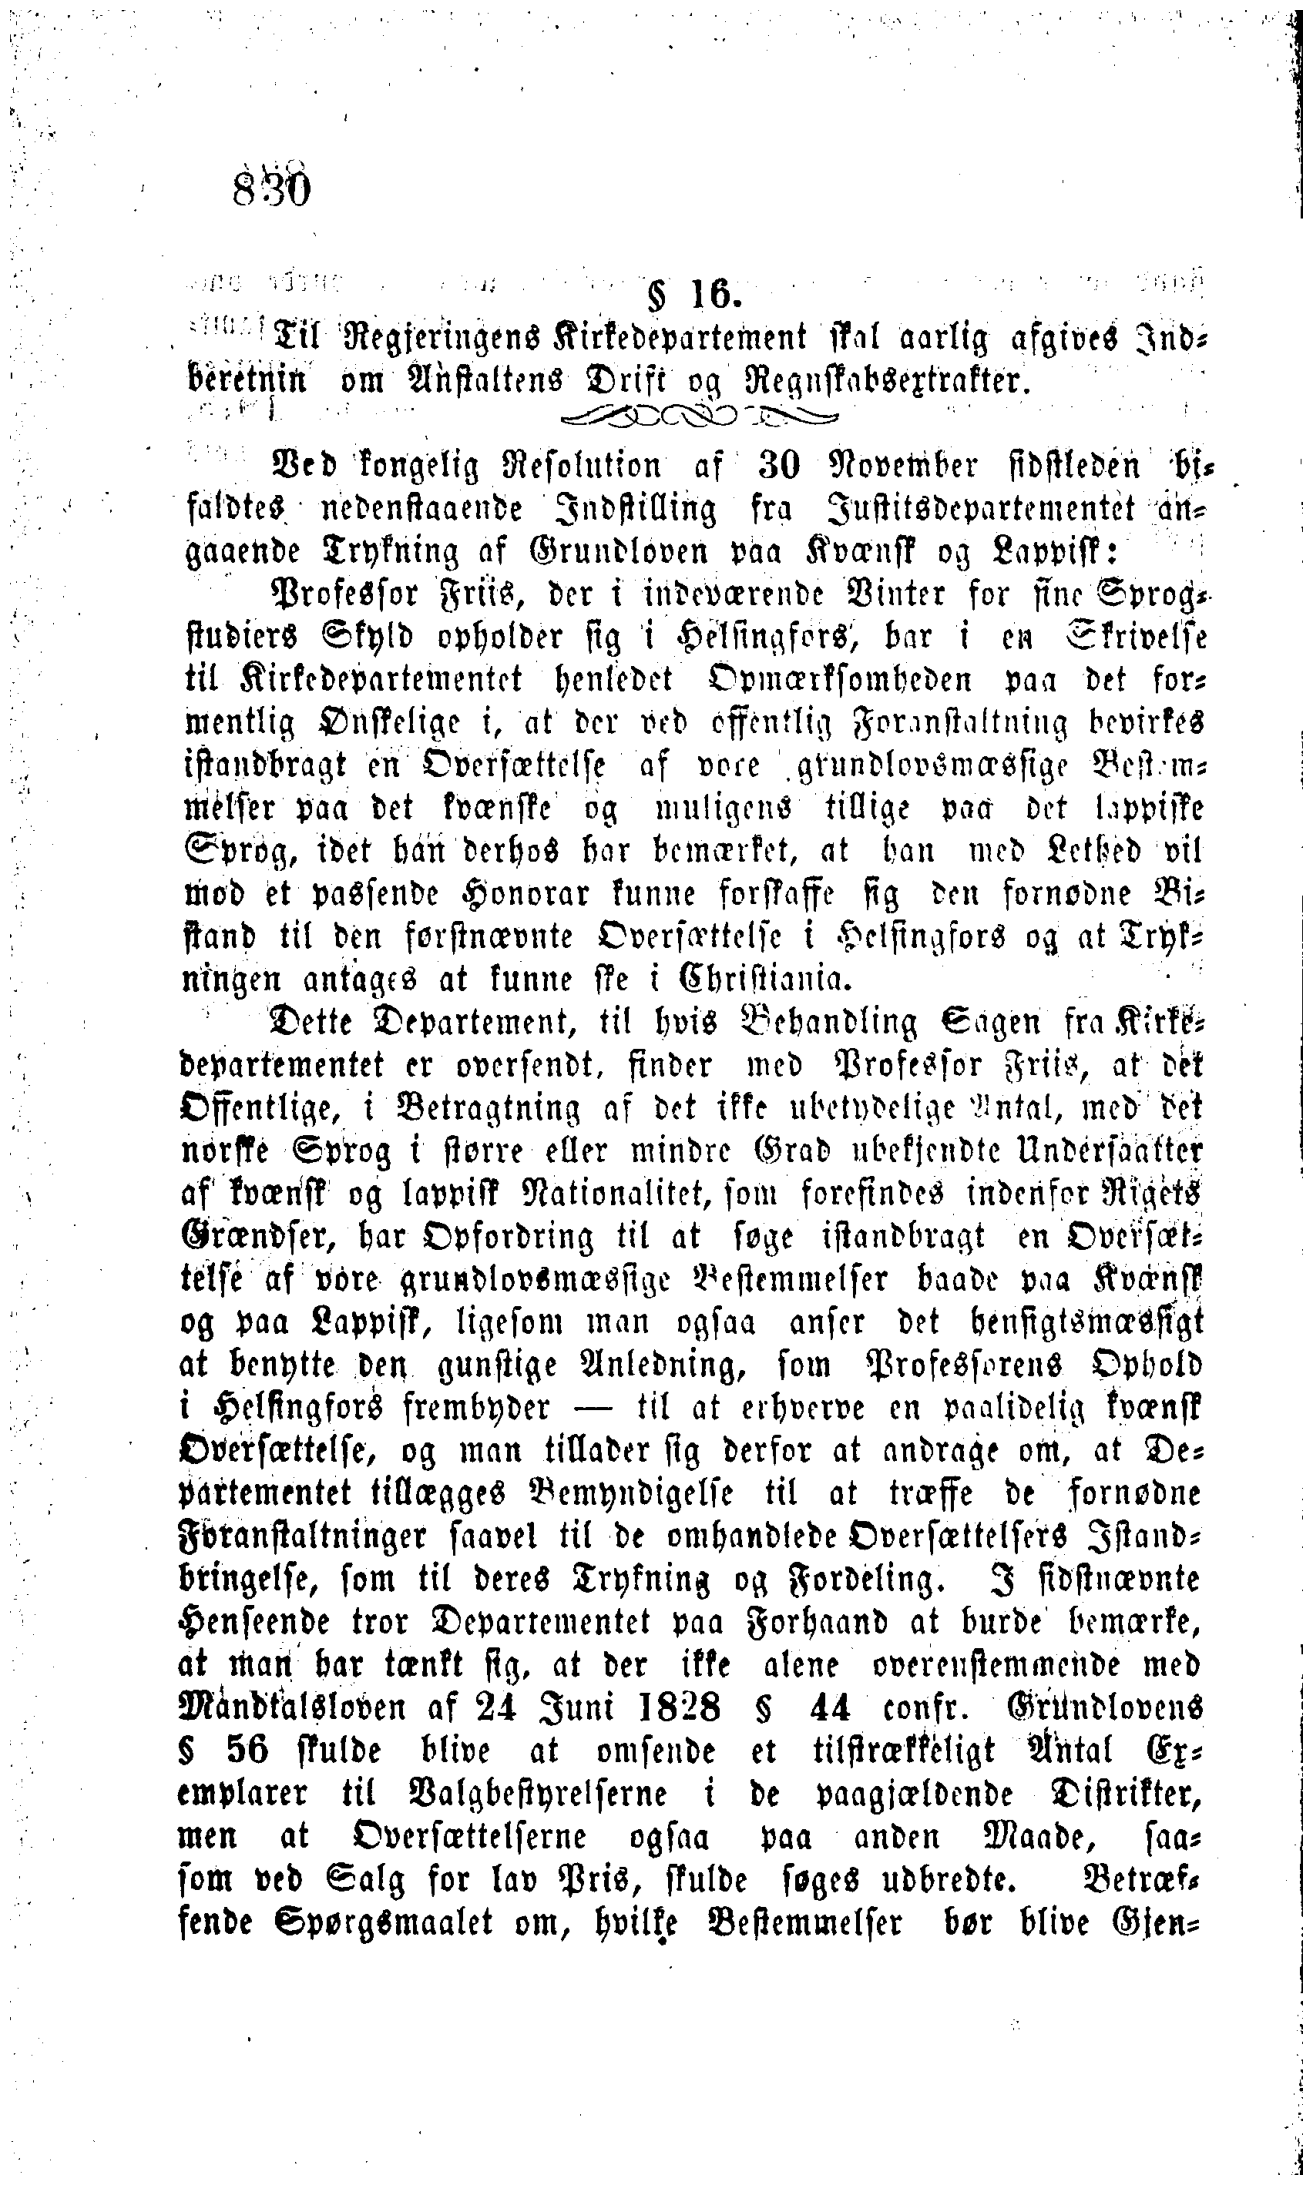

In [24]:
# Algoritme 0
urn        = 'URN:NBN:no-nb_digitidsskrift_2014042881056_001'
start_page = 892  
end_page   = 892 
scaling    = 'full'
tresholding_method = 0
dpi = 0
process_urn(urn, start_page,end_page,dpi)

import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Open the TIFF image
image = PILImage.open('./data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_full_treshold_0_dpi_0.processed.tif')

# Get the image dimensions
width, height = image.size

# Set figure size based on image size
fig = plt.figure(figsize=(width / 100, height / 100))  # Scale by 100 to get a reasonable display size

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axes for a cleaner look
plt.show()

### Treshold = 1

891
Processing page 892: https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digitidsskrift_2014042881056_001_0892/full/full/0/native.jpg


Estimating resolution as 332
Detected 3251 diacritics


Output saved to: ./data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_full_treshold_1_dpi_0


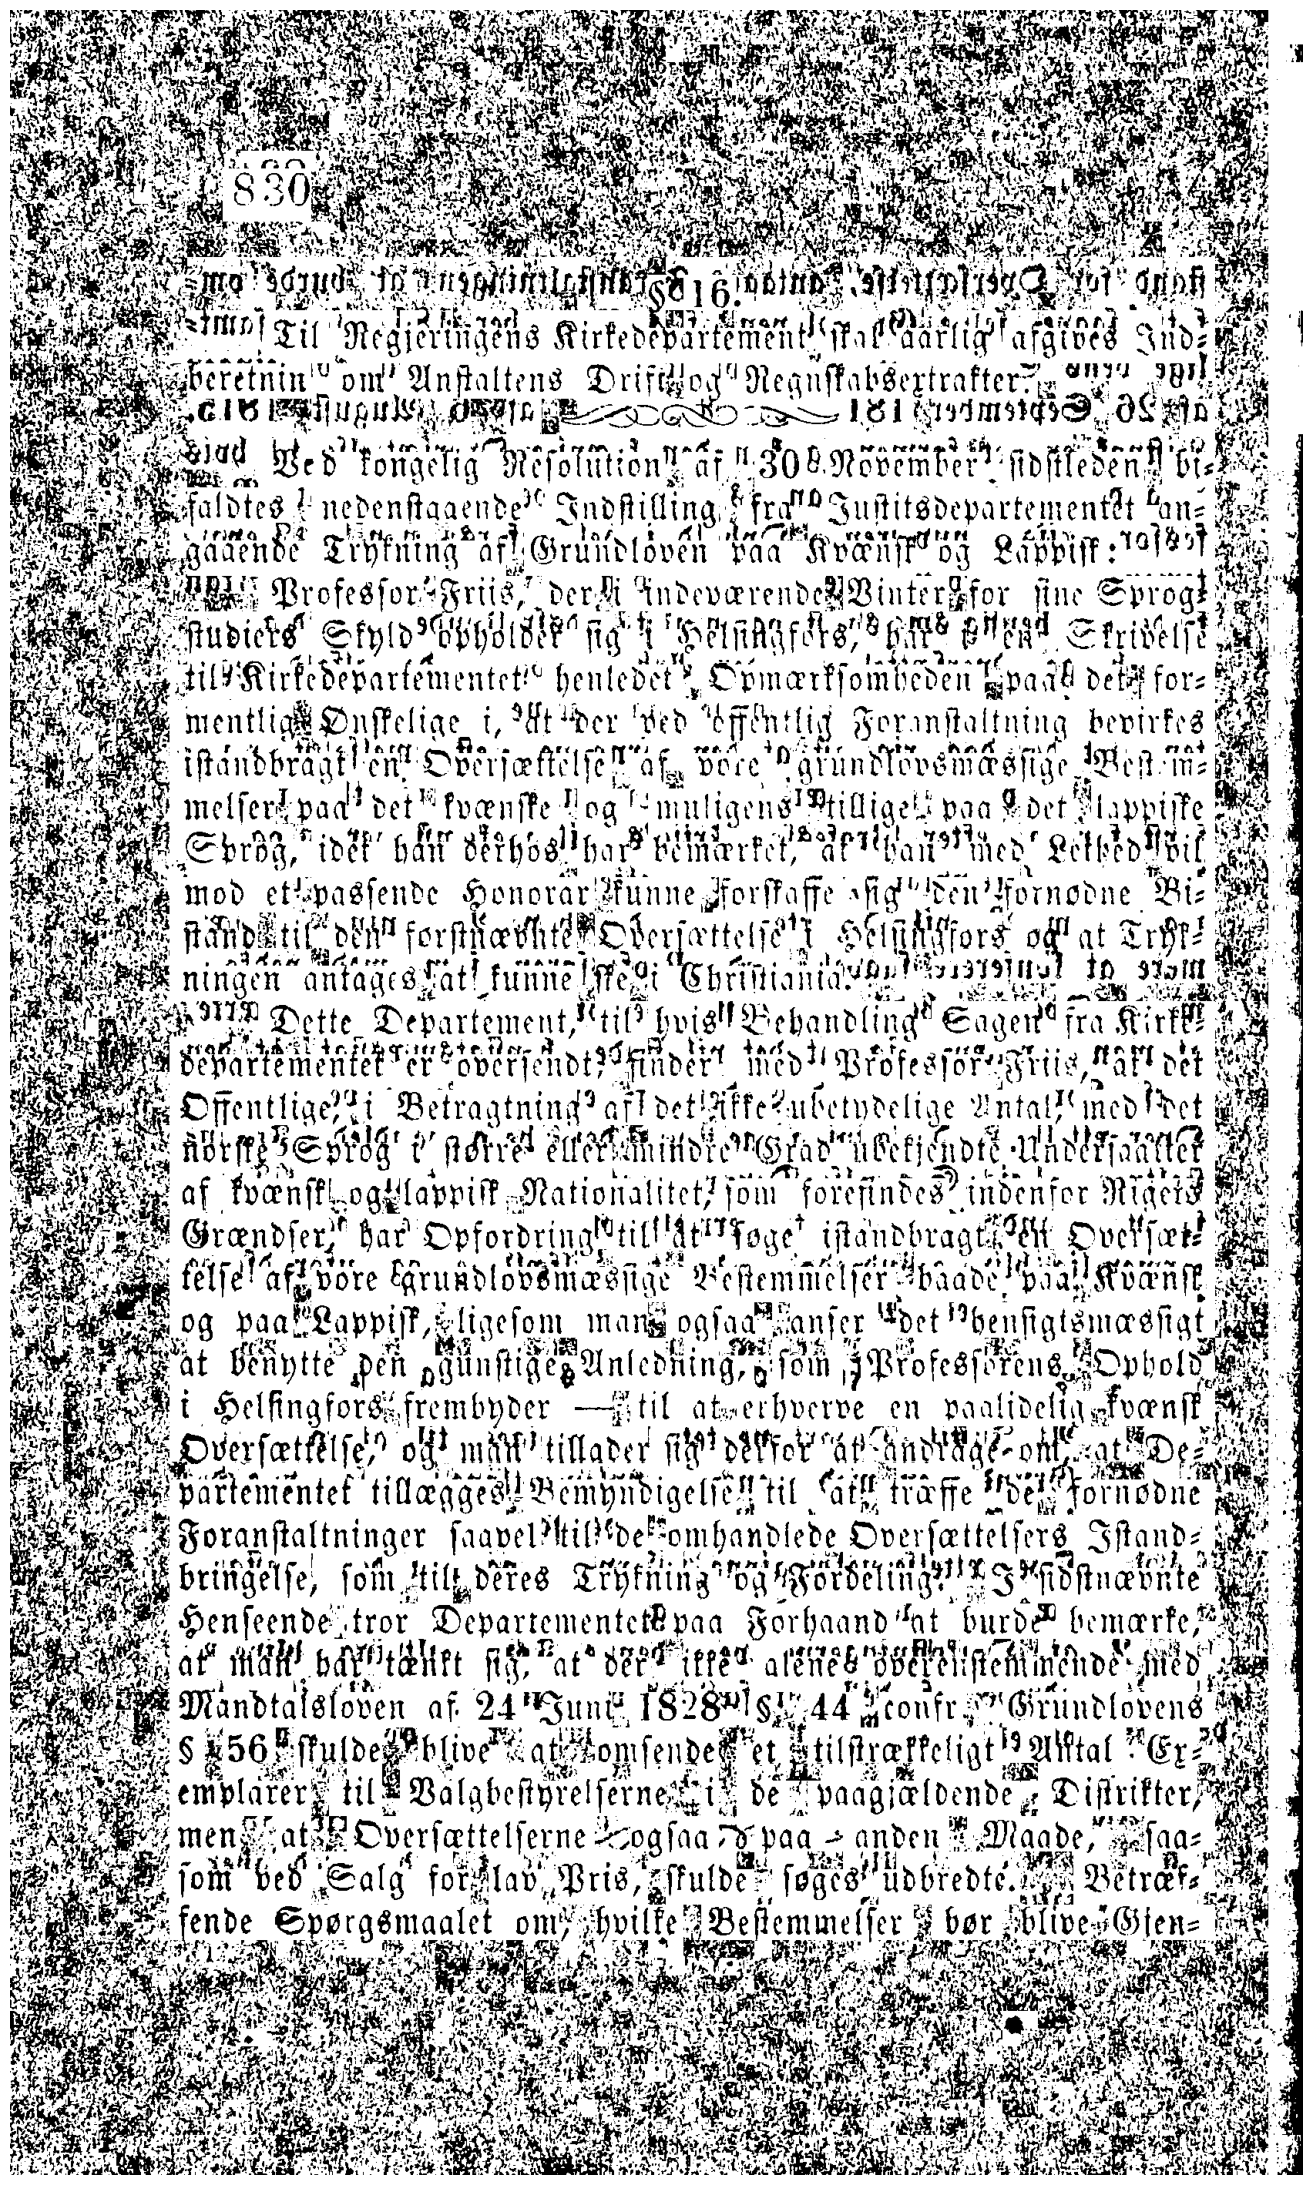

In [33]:
# Algoritme 1
urn        = 'URN:NBN:no-nb_digitidsskrift_2014042881056_001'
start_page = 892  
end_page   = 892 
scaling    = 'full'
tresholding_method = 1
dpi = 0
process_urn(urn, start_page,end_page,dpi)

import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Open the TIFF image
image = PILImage.open('./data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_full_treshold_1_dpi_0.processed.tif')

# Get the image dimensions
width, height = image.size

# Set figure size based on image size
fig = plt.figure(figsize=(width / 100, height / 100))  # Scale by 100 to get a reasonable display size

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axes for a cleaner look
plt.show()

### Treshold = 2

891
Processing page 892: https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digitidsskrift_2014042881056_001_0892/full/full/0/native.jpg


Estimating resolution as 428
Detected 94 diacritics


Output saved to: ./data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_full_treshold_2_dpi_0


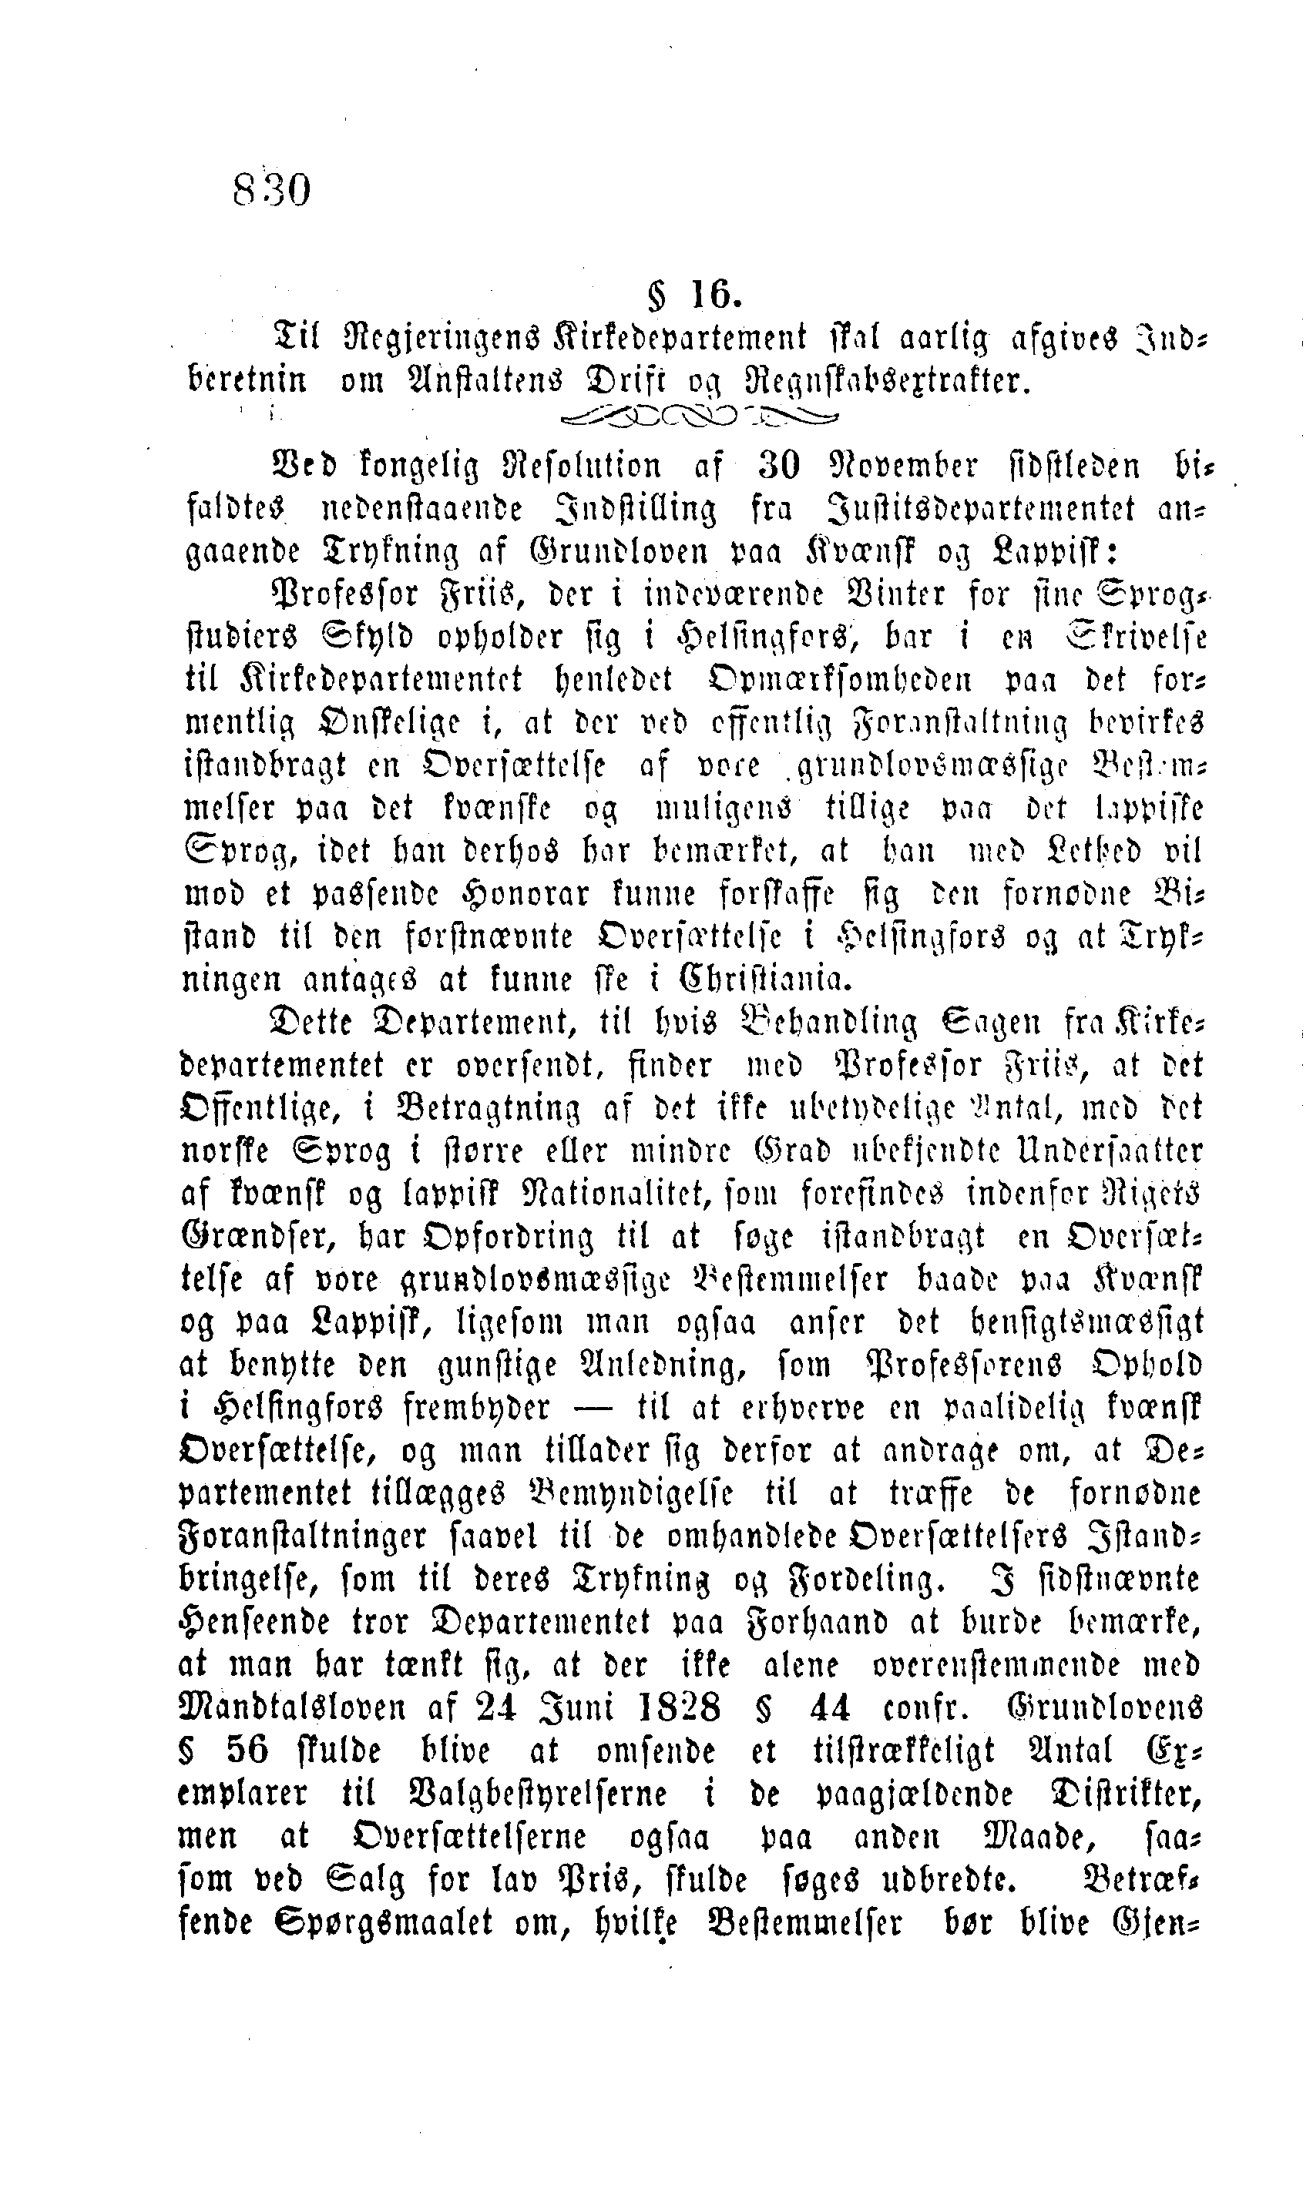

In [34]:
# Algoritme 2
urn        = 'URN:NBN:no-nb_digitidsskrift_2014042881056_001'
start_page = 892  
end_page   = 892 
scaling    = 'full'
tresholding_method = 2
dpi = 0
process_urn(urn, start_page,end_page,dpi)

import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Open the TIFF image
image = PILImage.open('./data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_full_treshold_2_dpi_0.processed.tif')

# Get the image dimensions
width, height = image.size

# Set figure size based on image size
fig = plt.figure(figsize=(width / 100, height / 100))  # Scale by 100 to get a reasonable display size

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axes for a cleaner look
plt.show()

In [ ]:
Ut fra visuell inspeksjon, ser det ut til at algoritme 2 og fullskale bilde gir det beste binæriserte resultatet.


## Resultat
Vi avslutter med å ta opp teksten slik den var i utgangspunktet og tekstne med justert parametre.

### Før

In [36]:
! cat ./data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_pct_50_treshold_0_dpi_400.txt

830

5             § 16.
.    Til Regferingens Kirkedepartement skal aarlig afgives Ind-
beretnin om Anftaltens 3; 3 377 Nmst poertratter-

––ØØ

Bed kongelig Feføkition eake af 30 November sidstleden bi-

faldtes nedenstaaende Indstilling fra Justitsdepartementet an-
gaaende Trykning af Grundloven paa Kvænsk og Nadrist    §

Professor Friis, der i indeværende Vinter for sine Sprog-
studiers Skyld opholder sig i Helsingfors, bar i en Skrivelse
til Kirkedepartementet henledet Opmærksomheden paa det for-
mentlig Ønskelige i, at der ved offentlig Foranstaltning bevirkes
istandbragt en Oversættelse af vore grundlovsmæssige Bestm-
melser paa det kvænske og muligens. tillige paa det lappiske
Svrog, idet han derhos har bemærket, at ban med Lethed vil
mod et passende Honorar kunne forskaffe sig den fornødne Bi-
stand til den forstnævnte Oversættelse i Helsingfors og at Tryk-
ningen antages at kunne ske i Christiania.

Dette Departement, til hvis Behandling Sagen fra Kirke-
departementet er ove

### Etter

In [37]:
! cat ./data/URN_NBN_no-nb_digitidsskrift_2014042881056_001/891_full_treshold_2_dpi_0.txt

O
0
D

§ 16.

Til Regjeringens Kirkedepartement skal aarlig afgives Ind-

bereknin om Anstaltens Drift og Regnskabsextrakter.
ØMMBû–

Ved kongelig Resolution af 30 November sidstleden bi-
faldtes nedenstaaende Indstilling fra Justitsdepartementet an-
gaaende Trykning af Grundloven paa Kvænsk og Lappisk:

Professor Friis, der i indeværende Vinter for sine Sprog-
studiers Skyld opholder sig i Helsingfors, har i en Srrivelse
til Kirkedepartementet henledet Opmærksomheden paa det for-
mentlig Ønskelige i, at der ved offentlig Foranstaltning bevirkes
istandbragt en Oversættelse af vore grundlovsmæssige Bestem-
melser paa det kvænske og muligens tillige paa det lappiske
Sprog, idet han derhos har bemærket, at han med Lethed vil
mod et passende Honorar kunne forskaffe sig den fornødne Bi-
stand til den førstnævnte Oversættelse i Helsingfors og at Tryk-
ningen antages at kunne ske i Christiania.

Dette Departement, til hvis Behandling Sagen fra Kirke-
departementet er oversendt, finder med Pro